In [1]:
# This notebook contains a naive mlp for garbage classification
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import utils
from vocab import Vocabulary
import pandas as pd
import numpy as np
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader

seed = 666
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [2]:
import os
EMB_DIM = 100 # embedding dimension to be used, choose from [50, 100, 200, 300]
glove_path = os.path.expanduser('~/Downloads/glove.6B.{}d.txt'.format(EMB_DIM))
embedding_dict = utils.load_glove_to_dict(glove_path)

400000it [00:12, 31075.57it/s]


In [3]:
MAX_SEQ_LEN = 10 # The maximum input sequence length, if longer, truncate; if shorter, pad

complete_csv_path = './preprocessed.csv'
complete_df = pd.read_csv(complete_csv_path)

complete_vocab = utils.build_vocab(complete_df)

wvecs = utils.build_wvecs(embedding_dict, complete_vocab)

train_csv_path = './train.csv'
val_csv_path = './val.csv'
test_csv_path = './test.csv'

In [4]:
# Load dataset
train_dataset = utils.GarbageDataset(train_csv_path, complete_vocab, MAX_SEQ_LEN)
val_dataset = utils.GarbageDataset(val_csv_path, complete_vocab, MAX_SEQ_LEN)
test_dataset = utils.GarbageDataset(test_csv_path, complete_vocab, MAX_SEQ_LEN)

# Construct dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=utils.collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=utils.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=utils.collate_fn)

In [5]:
class baseline_mlp(nn.Module):
    # Baseline mlp for garbage classification
    def __init__(self, embedding_dim, vocab_size, max_seq_length=MAX_SEQ_LEN):
        super(baseline_mlp, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.fc1 = nn.Linear(embedding_dim * max_seq_length, 100)
        self.fc2 = nn.Linear(100, 10)
        self.out = nn.Linear(10, 4)
    
    def forward(self, sequence):
        batch_size = sequence.shape[0]
        embedded = self.embedding(sequence)
        embedded = embedded.view(batch_size, -1)
        z = self.fc1(embedded)
        z = self.fc2(z)
        z = self.out(z)
        return z


In [6]:
def eval(loader: DataLoader, model):
    """Evaluate the classification accuracy of model on the given dataset

    Args:
        loader (DataLoader): 
        model ([type])
    """
    correct_counts = 0
    loss_sum = 0
    with torch.no_grad():
        for batch in loader:
            input, target = batch
            input, target = input.to(device), target.to(device)
            pred = model(input).squeeze(1)
            pred_classes = torch.argmax(pred, dim=1)
            correct_counts += torch.sum(pred_classes == target)
            loss = loss_fn(pred, target.long())
            loss_sum += loss.item() * target.shape[0]
    return correct_counts.item() / len(loader.dataset), loss_sum / len(loader.dataset)

In [7]:
use_cuda = False
device = torch.device("cuda:0" if use_cuda else "cpu") 

mlp = baseline_mlp(100, len(complete_vocab)).to(device)
mlp.embedding.weight.data.copy_(torch.from_numpy(np.array(wvecs)))
max_epoch = 100

optimizer = torch.optim.Adam(mlp.parameters(), lr=5e-4)

loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)

train_acc_stats = []
val_acc_stats = []
test_acc_stats = []
train_loss_stats = []
val_loss_stats = []
test_loss_stats = []

print('Start training')
for epoch in range(max_epoch):
    mlp.train()
    epoch_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input, target = batch
        input, target = input.to(device), target.to(device)
        pred = mlp(input).squeeze(1)
        loss = loss_fn(pred, target.long())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * target.shape[0]

    mlp.eval()

    val_acc, val_loss = eval(val_loader, mlp)
    train_acc, train_loss = eval(train_loader, mlp)
    test_acc, test_loss = eval(test_loader, mlp)

    val_acc_stats.append(val_acc)
    val_loss_stats.append(val_loss)
    train_acc_stats.append(train_acc)
    train_loss_stats.append(train_loss)
    test_acc_stats.append(test_acc)
    test_loss_stats.append(test_loss)

    print('Epoch:{}\tTrain Loss:{:4f}\tTrain Acc:{:4f}\tVal Loss:{:4f}\tVal Acc:{:4f}\tTest Loss:{:4f}\tTest Acc:{:4f}\t'.format(
        epoch+1, train_loss, train_acc, val_loss, val_acc,test_loss,test_acc))


Start training
Epoch:1	Train Loss:1.177743	Train Acc:0.466793	Val Loss:1.169404	Val Acc:0.417303	Test Loss:1.177866	Test Acc:0.440806	
Epoch:2	Train Loss:1.078463	Train Acc:0.533207	Val Loss:1.128280	Val Acc:0.478372	Test Loss:1.111033	Test Acc:0.496222	
Epoch:3	Train Loss:0.940378	Train Acc:0.627135	Val Loss:1.068112	Val Acc:0.524173	Test Loss:1.047116	Test Acc:0.534005	
Epoch:4	Train Loss:0.797013	Train Acc:0.687223	Val Loss:1.005089	Val Acc:0.547074	Test Loss:0.989400	Test Acc:0.569270	
Epoch:5	Train Loss:0.669050	Train Acc:0.745731	Val Loss:0.967563	Val Acc:0.580153	Test Loss:0.954097	Test Acc:0.602015	
Epoch:6	Train Loss:0.557485	Train Acc:0.787476	Val Loss:0.950643	Val Acc:0.597964	Test Loss:0.938581	Test Acc:0.624685	
Epoch:7	Train Loss:0.463511	Train Acc:0.832385	Val Loss:0.949860	Val Acc:0.608142	Test Loss:0.936132	Test Acc:0.647355	
Epoch:8	Train Loss:0.394843	Train Acc:0.858318	Val Loss:0.966770	Val Acc:0.633588	Test Loss:0.952639	Test Acc:0.659950	
Epoch:9	Train Loss:0.3740

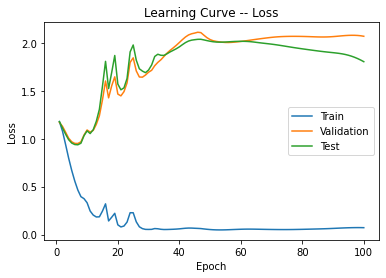

In [9]:
import matplotlib.pyplot as plt
plt.figure()
E = np.arange(1, max_epoch+1,1)
plt.title('Learning Curve -- Loss')
plt.plot(E, train_loss_stats, label='Train')
plt.plot(E, val_loss_stats, label='Validation')
plt.plot(E, test_loss_stats, label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

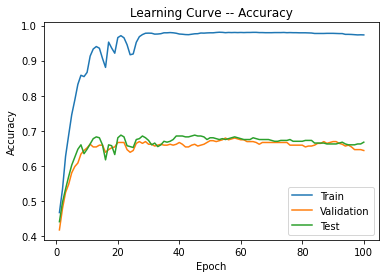

In [10]:
import matplotlib.pyplot as plt
plt.figure()
E = np.arange(1, max_epoch+1,1)
plt.title('Learning Curve -- Accuracy')
plt.plot(E, train_acc_stats, label='Train')
plt.plot(E, val_acc_stats, label='Validation')
plt.plot(E, test_acc_stats, label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()